# Late Fusion adapted by Transfer Squeeze Net

We will implement late fusion which is introduced in paper "Large-scale Video Classification with Convolutional Neural Network" 

The pipeline will be described in detail as below.

First, we will clip 5 frames from a video that we want to classify. 

Second, we will pass the 5 frames individually through trained squeeze net on image net to get a 1000 result which is used in image net label.

Third, we will concatinate 5 1000 result together to train another FC layer to give the labels that we want to classify our video. 

Above all, we will implement these late fusion approach and fine tune hyperparameters to yeild the best possbile result

# load Squeeze Net model and other libraries

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import json
import random

from cs231n.classifiers.squeezenet import SqueezeNet
from cs231n.data_utils import load_tiny_imagenet
from cs231n.image_utils import preprocess_image, deprocess_image
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# load dataset and preprocess
 - First, run DataProprocessing Notebook to get label (Y) and data (X) txt file. 
 - Second, move label and data txt file into this notebook foler
 - third, run the code below

In [2]:
def get_data(num_training = 1845, num_validation = 200, num_test = 200):
    ''' 
    load the training data provided by Jake 
    
    '''
    # load the data
    x_total = np.load("data_5_frame_more_data.npy")
    y_total = np.load("label_5_frame_more_data.npy")
        
#     # Subsample the data index for train, test, and validation
#     train_index = np.arange(0,num_training+num_validation+num_test)
#     valid_index = random.sample(range(0, num_training+num_validation+num_test), num_validation)
#     train_index = np.delete(train_index, valid_index)
#     index = random.sample(range(0, num_training+num_test), num_test)
#     test_index = train_index[index]
#     train_index = np.delete(train_index, index)
    train_index = np.load("train_index_1_frame.npy") 
    valid_index = np.load("valid_index_1_frame.npy")
    test_index = np.load("test_index_1_frame.npy")
    
    split_index = 50
    train_index = np.concatenate((train_index,valid_index[split_index:num_validation]))
    train_index = np.concatenate((train_index,test_index[split_index:num_test]))
    valid_index = valid_index[0:split_index]
    test_index = test_index[0:split_index]
    for each_valid_index in valid_index:
        remove_index = np.where((train_index/5).astype(int) == (each_valid_index/5).astype(int))
        train_index = np.delete(train_index, remove_index)
    
    for each_test_index in test_index:
        remove_index = np.where((train_index/5).astype(int) == (each_test_index/5).astype(int))
        train_index = np.delete(train_index, remove_index)
    
    # training data
    x_train = x_total[train_index]
    y_train = y_total[train_index]
    # validation data
    x_val = x_total[valid_index]
    y_val = y_total[valid_index]
    # test data
    x_test = x_total[test_index]
    y_test = y_total[test_index]
    
#     # save the same index for fine tune the best model
#     np.save('train_index_5_frame.npy', train_index)
#     np.save('valid_index_5_frame.npy', valid_index)
#     np.save('test_index_5_frame.npy', test_index)
#     print (y_test)
#     print (np.where(y_test == 0))
#     print (np.where(y_test == 1))
#     print (np.where(y_test == 2))
#     print (np.where(y_test == 3))
#     print (10*'-')
#     print (np.where(y_val == 0))
#     print (np.where(y_val == 1))
#     print (np.where(y_val == 2))
#     print (np.where(y_val == 3))

#     # Subsample the data
#     # training data
#     mask_train = range(0, num_training)
#     x_train = x_total[mask_train]
#     y_train = y_total[mask_train]
#     # validation data
#     mask_val = range(num_training, num_training + num_validation)
#     x_val = x_total[mask_val]
#     y_val = y_total[mask_val]
#     # test data
#     mask_test = range(num_training+num_validation, num_training+num_validation+num_test)
#     x_test = x_total[mask_test]
#     y_test = y_total[mask_test]
    
    # normalize the data: subtract the mean
    mean_video = np.floor(np.mean(x_train, axis=0))
    x_train = x_train - mean_video
    x_val = x_val - mean_video
    x_test = x_test - mean_video
    
    return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = get_data()

print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (1780, 5, 224, 224, 3)
Train labels shape:  (1780,)
Validation data shape:  (50, 5, 224, 224, 3)
Validation labels shape:  (50,)
Test data shape:  (50, 5, 224, 224, 3)
Test labels shape:  (50,)


# define to train the last layer

In [3]:
def my_model(rg, lr, dr, dc, FC_size):
    tf.reset_default_graph()
    sess = get_session()
    SAVE_PATH = 'cs231n/datasets/squeezenet.ckpt'
    model = SqueezeNet(save_path=SAVE_PATH, sess=sess)
    
    regularizers = 0
    NUM_CLASSES = 4 
    with tf.variable_scope('classifier_squeeze_frame'):
        with tf.variable_scope('layer0'):
            FRAME_PER_VIDEO = tf.constant(5, dtype='int32')
            x = model.features
            dims = tf.shape(x)
            N,H,W,C = dims[0], dims[1], dims[2], dims[3]
            x = tf.reshape(x, [tf.to_int32(N/FRAME_PER_VIDEO), H*W*C*FRAME_PER_VIDEO]) 
            W1 = tf.get_variable("weights1",shape=[432640,FC_size])
            b1 = tf.get_variable("bias1",shape=[FC_size])
            x = tf.matmul(x,W1)+b1
            regularizers += tf.nn.l2_loss(W1)
            W2 = tf.get_variable("weights2",shape=[FC_size,NUM_CLASSES])
            b2 = tf.get_variable("bias2",shape=[NUM_CLASSES])
            x = tf.matmul(x,W2)+b2
            regularizers += tf.nn.l2_loss(W2)
            
    model.classifier = tf.reshape(x,[-1, NUM_CLASSES])
    total_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(model.labels, NUM_CLASSES), logits=model.classifier)
    mean_loss = tf.reduce_mean(total_loss + regularizers*rg)
    classifier_squeeze_variable = tf.contrib.framework.get_variables('classifier_squeeze_frame')
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = lr
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, dc, dr, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate) # select optimizer and set learning rate
    train_step_last_layer = optimizer.minimize(mean_loss, var_list = classifier_squeeze_variable)
    train_step_all_layer = optimizer.minimize(mean_loss)
    return sess, model, mean_loss, train_step_last_layer, train_step_all_layer  

# define run model

In [4]:
def run_model(session, model, loss_val, Xd, yd,
              epochs=1, batch_size=40, print_every=100,
              training=None, plot_losses=False):
    # create confusion matrix holder
    N = 4
    conf_matrix = np.zeros((N,N))
    
    # total acc list
    total_correct_list = []
    
    # have tensorflow compute accuracy
    pred_label = tf.argmax(model.classifier,1)
    correct_prediction = tf.equal(tf.argmax(model.classifier,1), model.labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [pred_label, loss_val, correct_prediction, accuracy]
    
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            X_batch = Xd[idx,:]
            N,F,H,W,C = X_batch.shape
            X_batch_reshape = np.reshape(X_batch, [N*F,H,W,C])
            feed_dict = {model.image: X_batch_reshape,
                         model.labels: yd[idx]}
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            pred_label_val, loss, corr, _ = session.run(variables,feed_dict=feed_dict)

            for index in range(len(pred_label_val)):
                row_index = yd[idx][index]
                col_index = pred_label_val[index]
                conf_matrix[row_index][col_index] += 1
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_correct_list.append(total_correct)
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct_list,conf_matrix

# plot the best model with parameter
--------------------------------------------------------------------------------
Conslusion
--------------------------------------------------------------------------------
Best hyperparam for rg, lr, dr, dc, FC_size is
[0.021240244724400854, 2.94459668253014e-05, 0.7829686179328141, 557, 100]
Best validation accuracy is 0.635000
Best test accuracy is 0.810000

INFO:tensorflow:Restoring parameters from cs231n/datasets/squeezenet.ckpt


INFO:tensorflow:Restoring parameters from cs231n/datasets/squeezenet.ckpt


Train last layer
Iteration 0: with minibatch training loss = 4.17 and accuracy of 0.33
Iteration 100: with minibatch training loss = 2.55 and accuracy of 0.67
Iteration 200: with minibatch training loss = 4.03 and accuracy of 0.17
Epoch 1, Overall loss = 3.15 and accuracy of 0.337


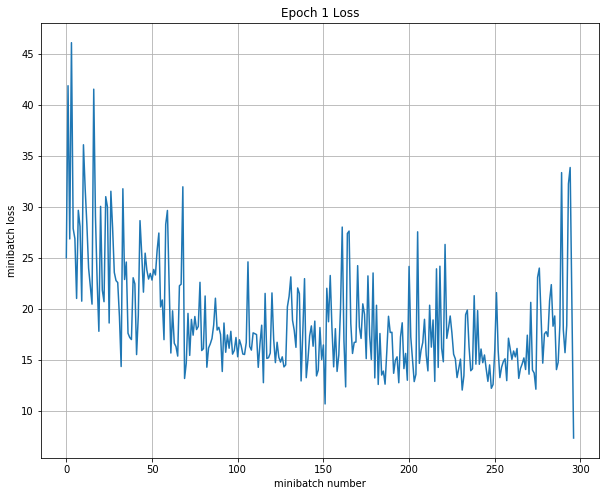

Iteration 300: with minibatch training loss = 4 and accuracy of 0
Iteration 400: with minibatch training loss = 2.36 and accuracy of 0.33
Iteration 500: with minibatch training loss = 1.99 and accuracy of 0.83
Epoch 2, Overall loss = 2.67 and accuracy of 0.394


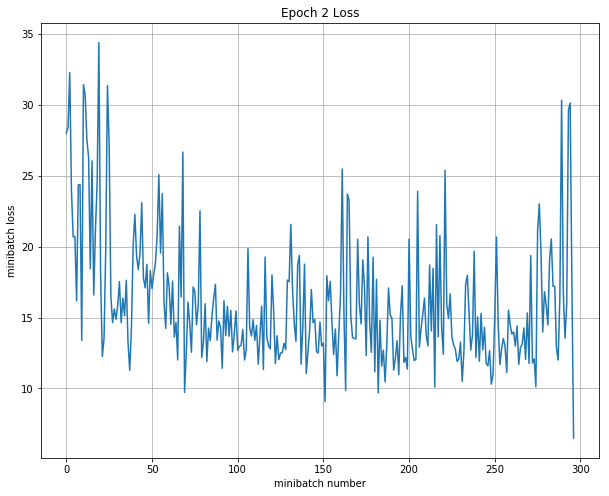

Iteration 600: with minibatch training loss = 2.5 and accuracy of 0.67
Iteration 700: with minibatch training loss = 2.86 and accuracy of 0.17
Iteration 800: with minibatch training loss = 1.98 and accuracy of 0.5
Epoch 3, Overall loss = 2.43 and accuracy of 0.422


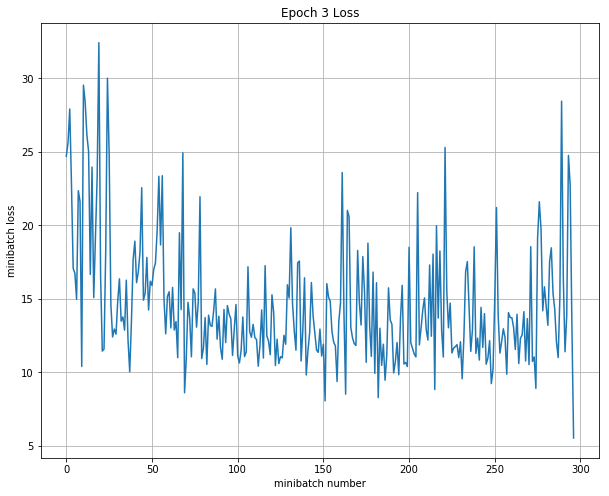

Iteration 900: with minibatch training loss = 1.36 and accuracy of 0.83
Iteration 1000: with minibatch training loss = 2.03 and accuracy of 0.33
Iteration 1100: with minibatch training loss = 2.36 and accuracy of 0.17
Epoch 4, Overall loss = 2.27 and accuracy of 0.444


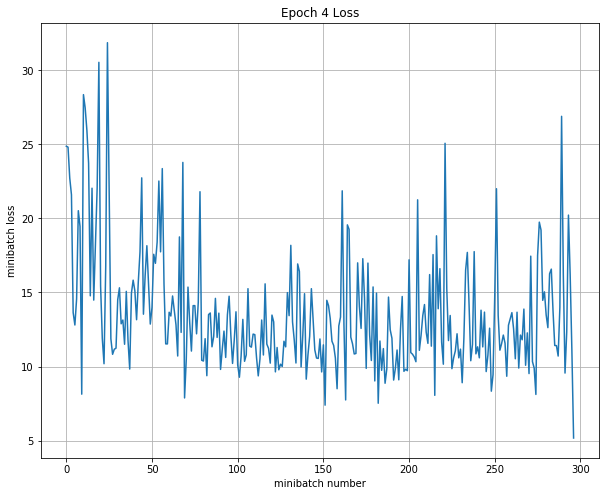

Iteration 1200: with minibatch training loss = 3.23 and accuracy of 0.33
Iteration 1300: with minibatch training loss = 1.48 and accuracy of 0.67
Iteration 1400: with minibatch training loss = 2.58 and accuracy of 0.17
Epoch 5, Overall loss = 2.1 and accuracy of 0.465


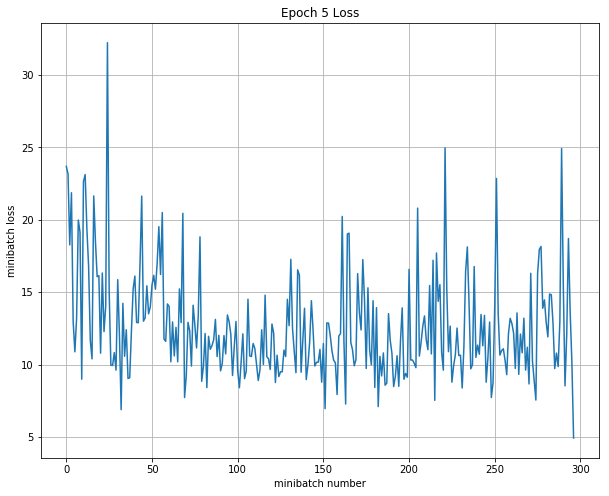

Iteration 1500: with minibatch training loss = 1.39 and accuracy of 0.83
Iteration 1600: with minibatch training loss = 1.57 and accuracy of 0.5
Iteration 1700: with minibatch training loss = 1.19 and accuracy of 0.83
Epoch 6, Overall loss = 1.99 and accuracy of 0.47


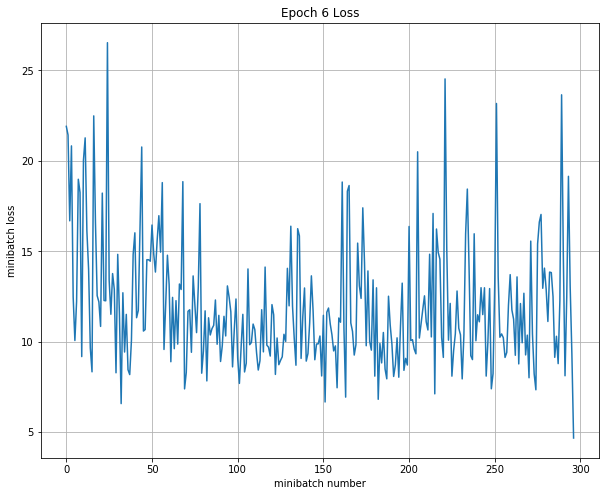

Iteration 1800: with minibatch training loss = 1.98 and accuracy of 0.5
Iteration 1900: with minibatch training loss = 1.53 and accuracy of 0.5
Iteration 2000: with minibatch training loss = 2.31 and accuracy of 0.17
Epoch 7, Overall loss = 1.91 and accuracy of 0.484


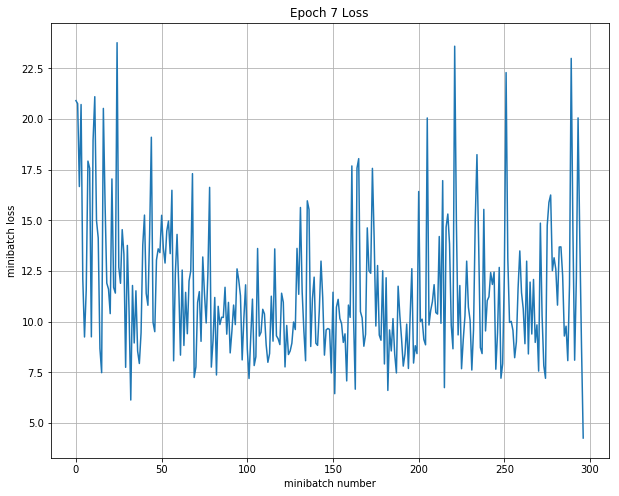

Iteration 2100: with minibatch training loss = 2.74 and accuracy of 0
Iteration 2200: with minibatch training loss = 1.76 and accuracy of 0.5
Iteration 2300: with minibatch training loss = 3.72 and accuracy of 0.17
Epoch 8, Overall loss = 1.84 and accuracy of 0.49


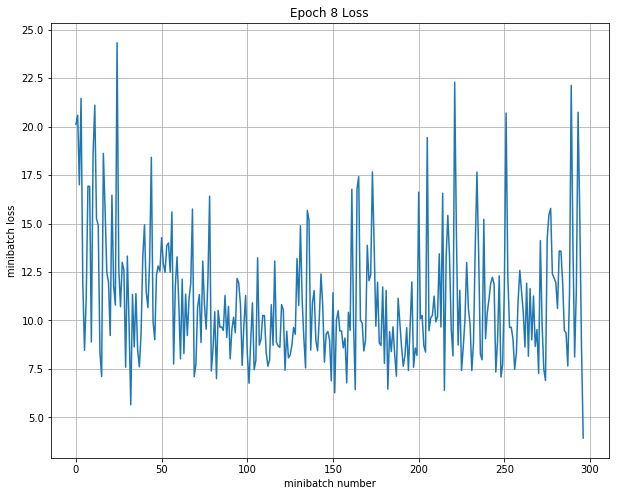

Iteration 2400: with minibatch training loss = 4.14 and accuracy of 0.17
Iteration 2500: with minibatch training loss = 1.3 and accuracy of 0.67
Iteration 2600: with minibatch training loss = 1.9 and accuracy of 0.17
Epoch 9, Overall loss = 1.78 and accuracy of 0.496


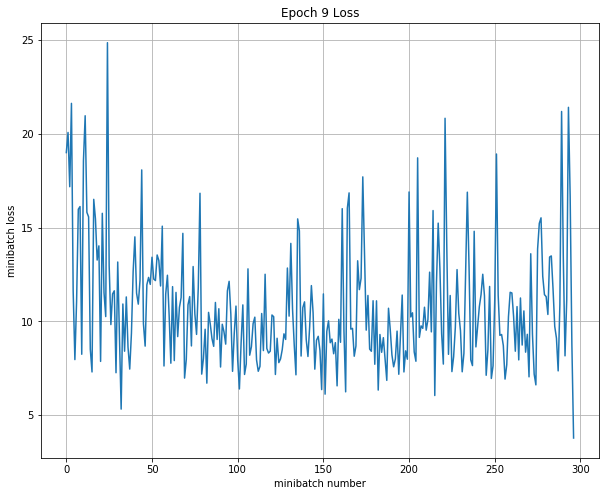

Iteration 2700: with minibatch training loss = 1.67 and accuracy of 0.67
Iteration 2800: with minibatch training loss = 1.51 and accuracy of 0.5
Iteration 2900: with minibatch training loss = 1.54 and accuracy of 0.67
Epoch 10, Overall loss = 1.74 and accuracy of 0.497


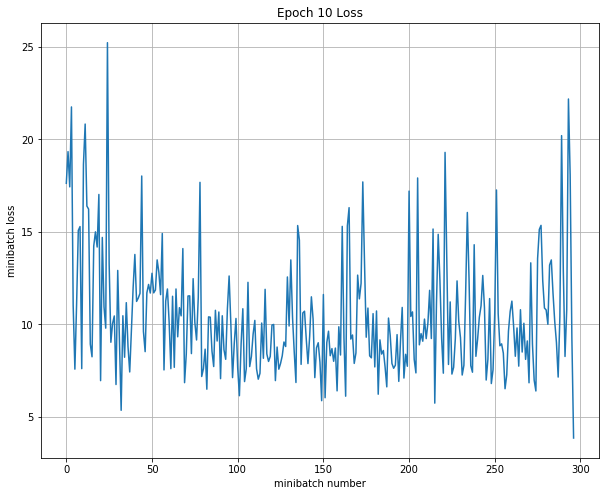

Train all layer
Iteration 0: with minibatch training loss = 2.31 and accuracy of 0.33
Iteration 100: with minibatch training loss = 1.31 and accuracy of 0.67
Iteration 200: with minibatch training loss = 1.05 and accuracy of 0.83
Epoch 1, Overall loss = 1.4 and accuracy of 0.633


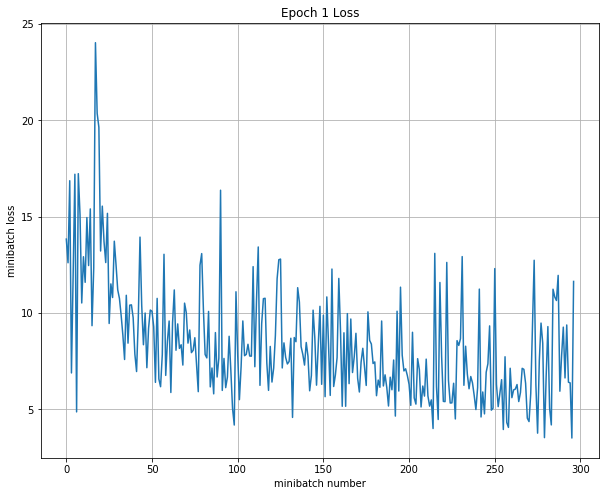

Iteration 300: with minibatch training loss = 0.699 and accuracy of 1
Iteration 400: with minibatch training loss = 0.616 and accuracy of 1
Iteration 500: with minibatch training loss = 0.73 and accuracy of 0.83
Epoch 2, Overall loss = 0.953 and accuracy of 0.797


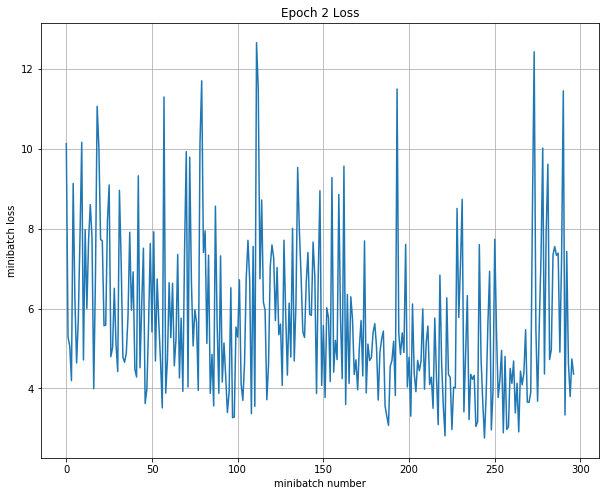

Iteration 600: with minibatch training loss = 0.835 and accuracy of 0.83
Iteration 700: with minibatch training loss = 0.773 and accuracy of 0.67
Iteration 800: with minibatch training loss = 0.683 and accuracy of 0.83
Epoch 3, Overall loss = 0.729 and accuracy of 0.889


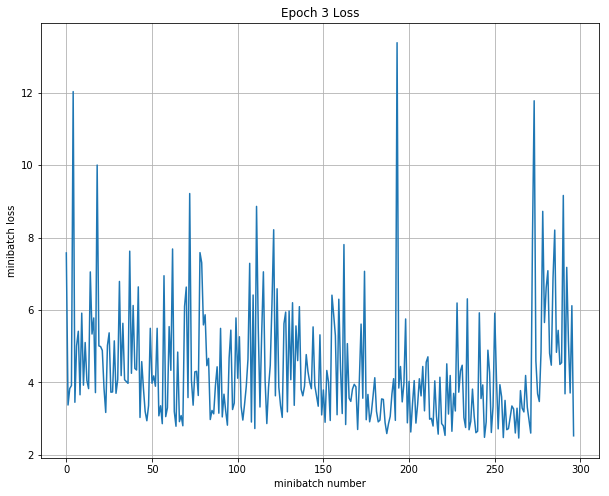

Iteration 900: with minibatch training loss = 0.642 and accuracy of 1
Iteration 1000: with minibatch training loss = 0.693 and accuracy of 1
Iteration 1100: with minibatch training loss = 0.479 and accuracy of 1
Epoch 4, Overall loss = 0.6 and accuracy of 0.932


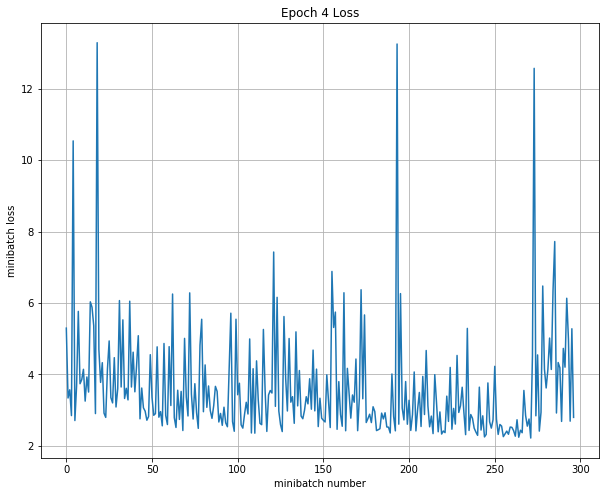

Iteration 1200: with minibatch training loss = 0.473 and accuracy of 1
Iteration 1300: with minibatch training loss = 0.611 and accuracy of 0.83
Iteration 1400: with minibatch training loss = 0.378 and accuracy of 1
Epoch 5, Overall loss = 0.518 and accuracy of 0.946


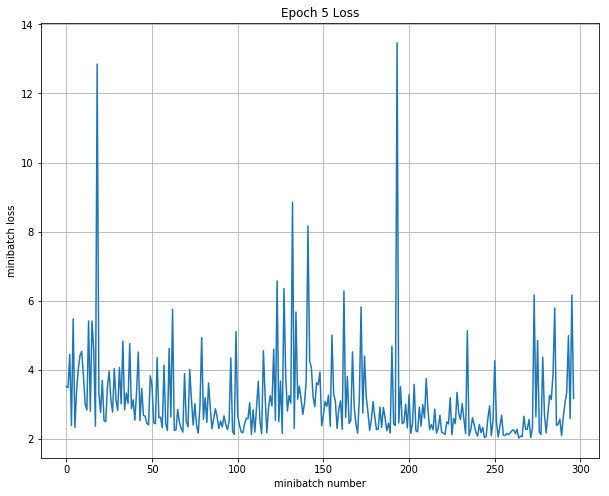

Iteration 1500: with minibatch training loss = 0.642 and accuracy of 0.83
Iteration 1600: with minibatch training loss = 0.586 and accuracy of 0.83
Iteration 1700: with minibatch training loss = 0.399 and accuracy of 1
Epoch 6, Overall loss = 0.442 and accuracy of 0.958


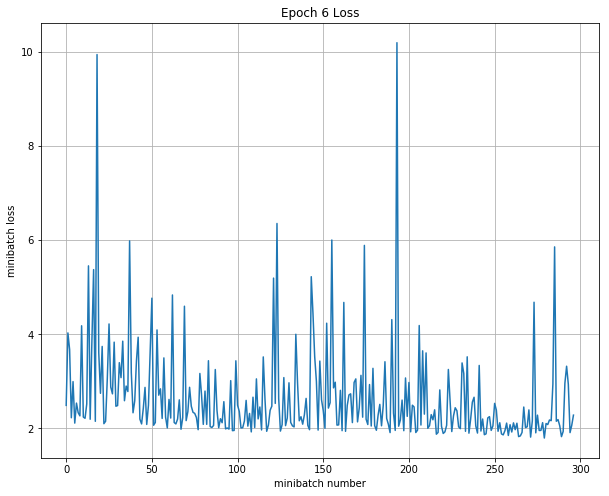

Iteration 1800: with minibatch training loss = 1.71 and accuracy of 0.67
Iteration 1900: with minibatch training loss = 0.293 and accuracy of 1
Iteration 2000: with minibatch training loss = 0.316 and accuracy of 1
Epoch 7, Overall loss = 0.392 and accuracy of 0.967


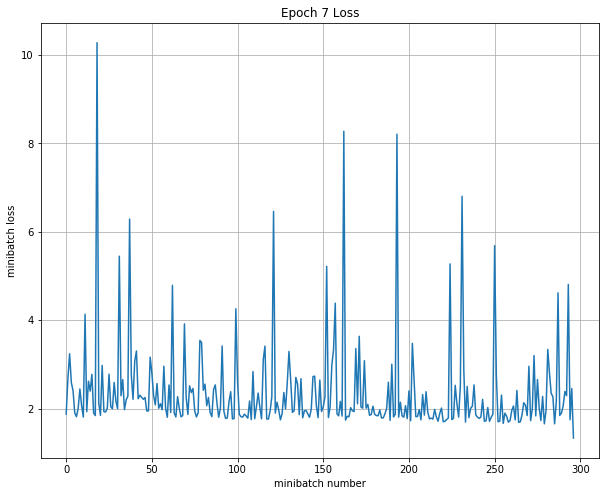

Iteration 2100: with minibatch training loss = 0.44 and accuracy of 0.83
Iteration 2200: with minibatch training loss = 0.329 and accuracy of 1
Iteration 2300: with minibatch training loss = 0.272 and accuracy of 1
Epoch 8, Overall loss = 0.372 and accuracy of 0.963


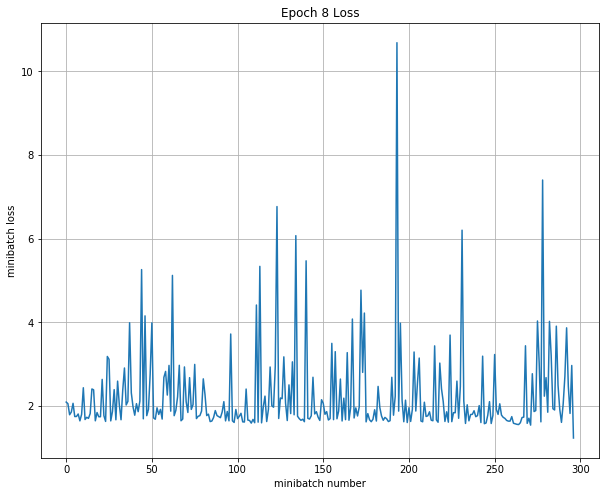

Iteration 2400: with minibatch training loss = 0.261 and accuracy of 1
Iteration 2500: with minibatch training loss = 0.263 and accuracy of 1
Iteration 2600: with minibatch training loss = 0.76 and accuracy of 0.83
Epoch 9, Overall loss = 0.329 and accuracy of 0.979


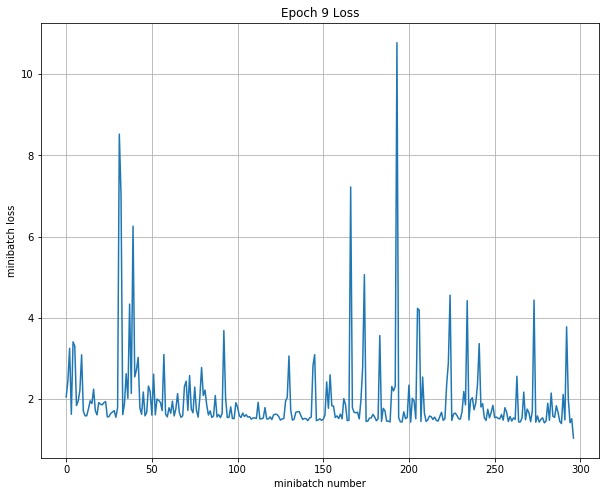

Iteration 2700: with minibatch training loss = 0.242 and accuracy of 1
Iteration 2800: with minibatch training loss = 0.255 and accuracy of 1
Iteration 2900: with minibatch training loss = 0.42 and accuracy of 1
Epoch 10, Overall loss = 0.297 and accuracy of 0.98


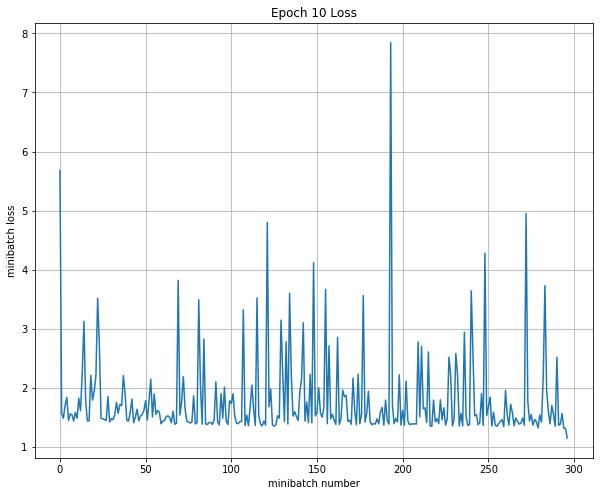

Validation
Epoch 1, Overall loss = 0.988 and accuracy of 0.9
Test
Epoch 1, Overall loss = 0.342 and accuracy of 0.98
Model saved in file: 5_frame_model.ckpt


In [6]:
best_acc = 0
best_sess = None
best_hyper = None
best_model = None
best_mean_loss = None
train_acc = 0
test_acc= 0
val_acc = 0

with tf.device("/gpu:0") as dev:
#     rg = 0.0212
#     lr = 2.9445e-05
#     dr = 0.7829
#     dc = 557
#     FC_size = 100
    rg = 0.027082
    lr = 0.000042
    dr = 0.891485 
    dc = 986
    FC_size = 100
    sess, model, mean_loss, train_step_last_layer, train_step_all_layer = my_model(rg, lr, dr, dc, FC_size)
    sess.run(tf.global_variables_initializer())
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    print('Train last layer')
    _, train_acc1, conf_matrix_train = run_model(sess,model,mean_loss,x_train,y_train,10,6,100,train_step_last_layer,True)
    print('Train all layer')
    _, train_acc2, conf_matrix_train = run_model(sess,model,mean_loss,x_train,y_train,10,6,100,train_step_all_layer,True)
    print('Validation')
    _, val_acc, conf_matrix_val = run_model(sess,model,mean_loss,x_val,y_val,1,200)
    print('Test')
    _, test_acc, conf_matrix_test = run_model(sess,model,mean_loss,x_test,y_test,1,200) 
    train_acc = np.concatenate((train_acc1,train_acc2))
    # Save the variables to disk.
    save_path = saver.save(sess, "5_frame_model.ckpt")
    print("Model saved in file: %s" % save_path)

[[ 18.   0.   0.   0.]
 [  0.   6.   0.   0.]
 [  1.   0.  12.   0.]
 [  0.   0.   0.  13.]]


([<matplotlib.axis.YTick at 0x7f8c0f0280f0>,
 <a list of 4 Text yticklabel objects>)

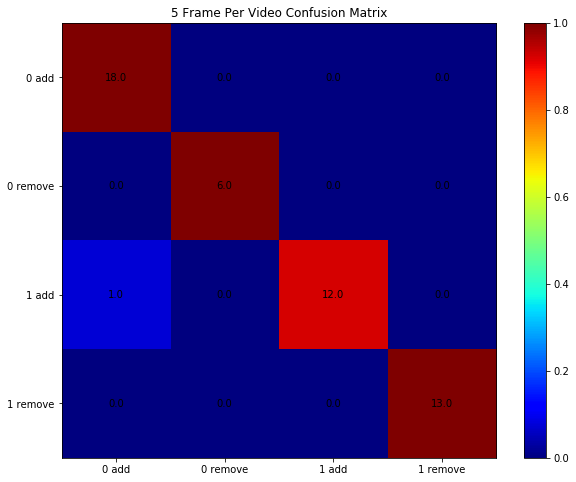

In [15]:
print (conf_matrix_test)
conf_arr = conf_matrix_test

norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        if a != 0:
            tmp_arr.append(float(j)/float(a))
        else: 
            tmp_arr.append(float(j))
    norm_conf.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)
alphabet = ['0 add', '0 remove', '1 add', '1 remove']
plt.title('5 Frame Per Video Confusion Matrix')
plt.xticks(range(width), alphabet[:width])
plt.yticks(range(height), alphabet[:height])

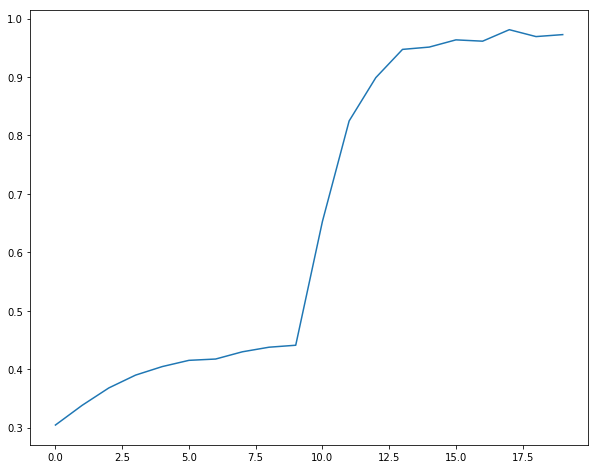

In [6]:
plt.plot(train_acc)

In [7]:
from tempfile import TemporaryFile
np.save('5_frame_train_acc.npy', train_acc)

In [2]:
frame1_acc = np.load("1_frame_train_acc_worse.npy")
frame3_acc = np.load("3_frame_train_acc.npy")
frame5_acc = np.load("5_frame_train_acc.npy")

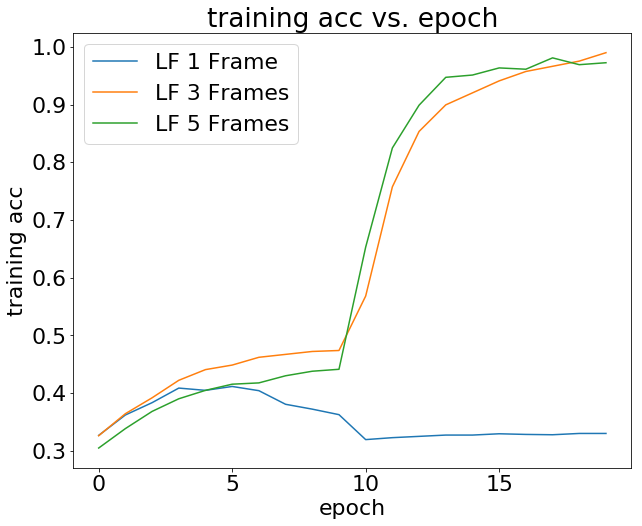

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
plt.plot(frame1_acc, label="LF 1 Frame")
plt.plot(frame3_acc, label="LF 3 Frames")
plt.plot(frame5_acc, label="LF 5 Frames")
plt.title('training acc vs. epoch')
plt.xlabel('epoch')
plt.ylabel('training acc')
plt.legend(loc=2,prop={'size':22})
plt.show()